If you found any errors, please, share them shvechikov.p@gmail.com

In [32]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Fixed

A fixed amount per share or a set percent of trade value, and includes all IB commissions, exchange and most regulatory fees with the exception of the transaction fees, which are passed through on all stock sales

In [152]:
def get_commission_fixed(n, p, sale=False):
    min_per_order = 1
    max_per_order = 0.01 * n * p 
    commission = n * 0.005
    commission = np.maximum(commission, min_per_order)
    commission = np.minimum(commission,  max_per_order)

    trans_fee = 0.0000221 * n * p * sale
    finra_activity = np.minimum(0.000119 * n, 5.95) 
    return commission + trans_fee + finra_activity

Если рассчитанная максимальная плата за ордер будет меньше установленной минимальной, то будет взиматься максимальная. Например, за сделку на покупку 10 акций по цене \\$0.20   будет взиматься $0.02 (10 акций * 0.005 за акцию = 0.05 комиссии, минимум 1.00 за ордер, установленный лимит в 10 акций * 0.20 * 1% = 0.02).

100 акций по цене USD 25 за акцию = USD 1.00

1,000 акций по цене USD 25 за акцию = USD 5.00

1,000 акций по цене USD 0.25 за акцию = USD 2.50

In [74]:
# check against examples
print(round(get_commission_fixed(10, .20), 10))
print(get_commission_fixed(100, 25))
print(get_commission_fixed(1000, 25))
print(get_commission_fixed(1000, .25))

0.02
1.0
5.0
2.5


Computations do not include
- Advisors fees and specialist fees (assuming you are not subscribed) 
- VAT cost (same for Fixed and Tiered)
- Partial execution mechanics (it is not clear, when and how this occurs) 
- Account for the Commission-free ETFs 
- Modified order mechanics

Unclear: 
- footnote 1 in the [Fixed pricing](https://www.interactivebrokers.co.uk/en/index.php?f=39753&p=stocks1) states: `Plus the applicable exchange, ECN and/or specialist fees based on execution venue.`, but at the very top of the pricing page, as well as in the notes they say `All exchange fees are included.`. 

# Tiered

Assmptions: 
- volume per month < 300 000 shares
- orders are executed with the priciest Remove Liquidity strategy (i.e. against an existing bid or offer on an order book)
- Island ECN is used for computation of exchange fees (one of the first ECN's and quite a popular one)
- `IB Tiered Commissions` in the `Transaction Fees` section of the [Tiered pricing page](https://www.interactivebrokers.co.uk/en/index.php?f=39753&p=stocks2)  do not include any other exchange, regulatory or clearing fees

In [223]:
def _compute_ladder_commission(n, verbose=False):
    per_share_usd_cutoffs = [0.0035, 0.002, 0.0015, 0.001, 0.0005]
    n_cutoffs = [300_000, 3_000_000, 20_000_000, 100_000_000, np.inf]
    costs = {}
    n_processed = 0
    for per_share_usd, cutoff in zip(per_share_usd_cutoffs, n_cutoffs):
        n_per_tier = min(cutoff - n_processed, n - n_processed)
        costs[cutoff] = n_per_tier * per_share_usd
        n_processed += n_per_tier
    total_cost = sum(costs.values())
    if verbose:
        return total_cost, costs
    else: 
        return total_cost

In [231]:
def get_commission_tiered(n, p, sale=False, verbose=False, add_liquid=False):
    min_per_order = 0.35
    max_per_order = 0.01 * n * p 
    commission = _compute_ladder_commission(n)
    commission = np.maximum(commission, min_per_order)
    commission = np.minimum(commission, max_per_order)
    
    # clearing fees
    clear_fee = np.minimum(0.00020  * n, 0.005 * n * p)
    
    # exchange fees for NASDAQ / Island
    # for NYSE commission is almost the same
    if p < 1: 
        if add_liquid: 
            exch_fee = 0
        else: 
            exch_fee = n * p * 0.0030       
    else: 
        if add_liquid:
            exch_fee = - 0.0021 * n
        else: 
            exch_fee = 0.0030 * n
        
    # transaction fees 
    trans_fee = 0.0000221 * n * p * sale
    nyse_pass_through = commission * 0.000175
    finra_pass_through = commission * 0.00056
    finra_activity = np.minimum(0.000119 * n, 5.95) 
  
    total_commission = commission + clear_fee + exch_fee + trans_fee + nyse_pass_through + finra_pass_through + finra_activity
   
    if verbose: 
        res = [ 
            ("IBKR commission", commission),
            ("Exchange fee", exch_fee), 
            ("Clearing  fee", clear_fee),
            ("Transaction fee", trans_fee), 
            ("NYSE pass-through", nyse_pass_through),
            ("Finra pass-through", finra_pass_through),
            ("Finra activity", finra_activity),
            ("TOTAL", total_commission)
        ]
        from tabulate import tabulate
        print(tabulate(res))

    return total_commission

In [232]:
# check pass  https://www.interactivebrokers.co.uk/en/index.php?f=40909
get_commission_tiered(30_000_000 , 5, sale=True, add_liquid=True, verbose=True)  

------------------  ------------
IBKR commission      41950
Exchange fee        -63000
Clearing  fee         6000
Transaction fee       3315
NYSE pass-through        7.34125
Finra pass-through      23.492
Finra activity           5.95
TOTAL               -11698.2
------------------  ------------


-11698.216749999992

In [236]:
# check pass  https://www.interactivebrokers.co.uk/en/index.php?f=40909
get_commission_fixed(30_000_000 , 5, sale=True)   

153320.95

In [235]:
# check pass  https://www.interactivebrokers.co.uk/en/index.php?f=40909
get_commission_tiered(30_000_000 , 5, sale=True, add_liquid=False, verbose=True)  

------------------  ------------
IBKR commission      41950
Exchange fee         90000
Clearing  fee         6000
Transaction fee       3315
NYSE pass-through        7.34125
Finra pass-through      23.492
Finra activity           5.95
TOTAL               141302
------------------  ------------


141301.78325

In [238]:
# check pass  https://www.interactivebrokers.co.uk/en/index.php?f=40909
get_commission_fixed(200000, 5, sale=True)  

1028.05

In [237]:
# check pass  https://www.interactivebrokers.co.uk/en/index.php?f=40909
get_commission_tiered(200000, 5, sale=True, verbose=True)  

------------------  ---------
IBKR commission      700
Exchange fee         600
Clearing  fee         40
Transaction fee       22.1
NYSE pass-through      0.1225
Finra pass-through     0.392
Finra activity         5.95
TOTAL               1368.56
------------------  ---------


1368.5645

Unclear: 
- (unrelated to computations, see Assumptions) Orders where the commission cap is applied do not count towards the monthly volume tiers
- (related to computations) exchange fees Island:  `NASDAQ < $1.00 per share, Remove liquidity cost = Trade Value * 0.0030`  
    - is the total cost `trade_value * 0.0030` or ` trade_value * 0.0030 * n` ?  Assuming the former. Cannot check, since their examples do not include`p < $1`
    
  


Note
* using SmartRouting, clients should be aware that IB may route the order to an exchange with a better quoted price but with substantially higher fees. In particular, clients should understand the ECN charges for removing liquidity when sending marketable orders for low priced stocks (under USD 2.50).
*

# Comparison

Tiered vs Fixed: 
- a rebate for executing a trade in a Regulation NMS stock at a market-maker, dark pool, or with a liquidity provider in the IB ATS, IB will pass the full amount of that rebate to Tiered-commission customers as a venue rebate ant to Fixed-commission customers as a commission discount. 
- one of the main difference between Fixed and Tiered is the ability to gain from the Add Liquidity strategy of placing an order (for Add Liquidity the commission [may be even negative](https://www.interactivebrokers.co.uk/en/index.php?f=40909&nhf=T)). 

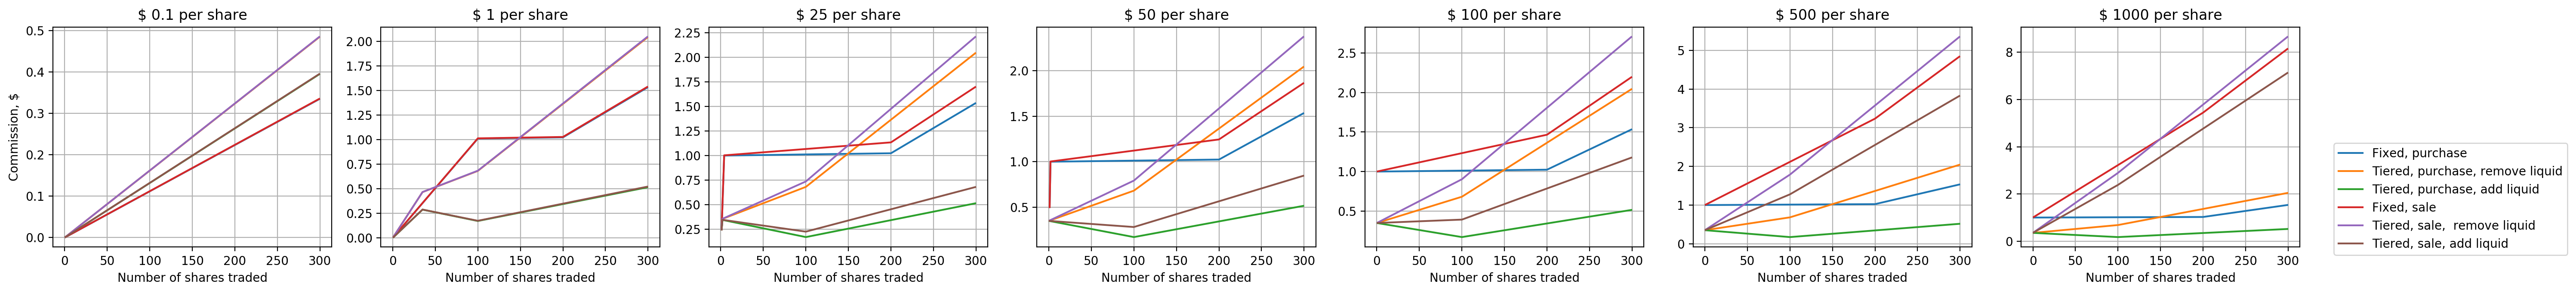

In [194]:
plt.figure(figsize=(30, 3.5), dpi=200)
prices = [0.1, 1, 25, 50, 100, 500, 1000]
for i, p in enumerate(prices):
    plt.subplot(1, len(prices), i+1)
    n = np.arange(1, 300)
    plt.title(f"$ {p} per share")
    plt.plot(n, get_commission_fixed(n, p), label="Fixed, purchase")
    plt.plot(n, get_commission_tiered(n, p), label="Tiered, purchase, remove liquid")
    plt.plot(n, get_commission_tiered(n, p, add_liquid=True), label="Tiered, purchase, add liquid")
    plt.plot(n, get_commission_fixed(n, p, sale=True), label="Fixed, sale")
    plt.plot(n, get_commission_tiered(n, p, sale=True), label="Tiered, sale,  remove liquid")
    plt.plot(n, get_commission_tiered(n, p, sale=True, add_liquid=True), label="Tiered, sale, add liquid")
    if i == 0:
        plt.ylabel("Commission, $")
    plt.xlabel("Number of shares traded")
    if i == len(prices) - 1: 
        plt.legend(bbox_to_anchor=(1.1, 0.5))
    plt.grid()
plt.tight_layout()
plt.savefig("C:/Users/Dell/Downloads/ib_commision.png")

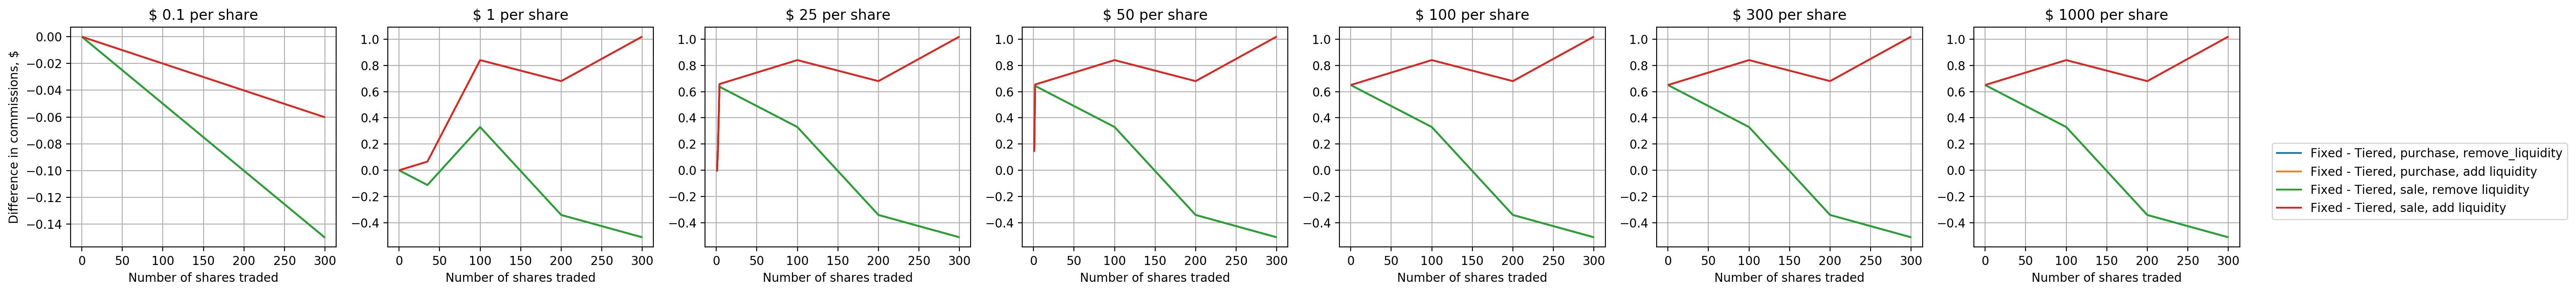

In [196]:
plt.figure(figsize=(30, 3.5), dpi=200)
prices = [0.1, 1, 25, 50, 100, 300, 1000]
for i, p in enumerate(prices):
    plt.subplot(1, len(prices), i+1)
    n = np.arange(1, 300)
    plt.title(f"$ {p} per share")
    plt.plot(n, get_commission_fixed(n, p) - get_commission_tiered(n, p), 
             label="Fixed - Tiered, purchase, remove_liquidity")
    plt.plot(n, get_commission_fixed(n, p) - get_commission_tiered(n, p, add_liquid=True), 
             label="Fixed - Tiered, purchase, add liquidity")
    plt.plot(n, get_commission_fixed(n, p, sale=True) - get_commission_tiered(n, p, sale=True), 
             label="Fixed - Tiered, sale, remove liquidity")
    plt.plot(n, get_commission_fixed(n, p, sale=True) - get_commission_tiered(n, p, sale=True, add_liquid=True), 
             label="Fixed - Tiered, sale, add liquidity")
    if i == 0:
        plt.ylabel("Difference in commissions, $")
    plt.xlabel("Number of shares traded")
    if i == len(prices) - 1: 
        plt.legend(bbox_to_anchor=(1.1, 0.5))
    plt.grid()
plt.tight_layout()
plt.savefig("C:/Users/Dell/Downloads/ib_commision_diff.png")
